# Import Library

In [16]:
import time
import numpy as np
import pandas as pd
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import category_encoders as ce
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
links = pd.read_csv('./ml-latest-small/links.csv')
movies = pd.read_csv('./ml-latest-small/movies.csv')
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
tags = pd.read_csv('./ml-latest-small/tags.csv')

In [3]:
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print(links.shape)
links.head()

(9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
print(tags.shape)
tags.head()

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [17]:
df = pd.merge(movies, ratings, on='movieId')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


# EDA

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


## Missing Value

<AxesSubplot:>

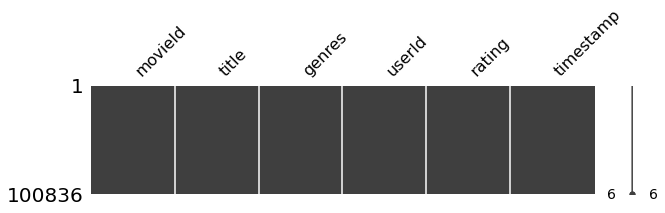

In [19]:
missingno.matrix(df, figsize = (10,2))

In [22]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

## Visualization

- 평점에 따른 유저의 수

Text(0.5, 1.0, 'Rating by Users')

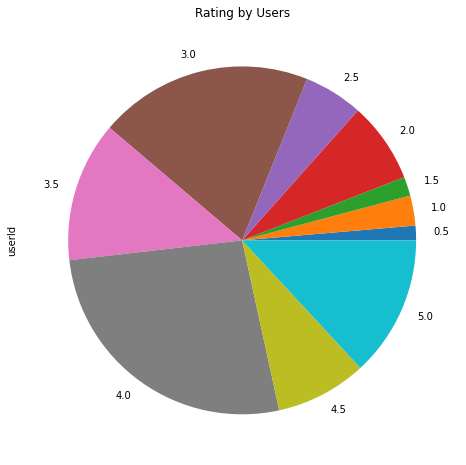

In [27]:
plt.figure(figsize = (15,8))
df.groupby('rating')['userId'].count().plot(kind="pie")
plt.title('Rating by Users')

Text(0.5, 1.0, 'Rating by Users')

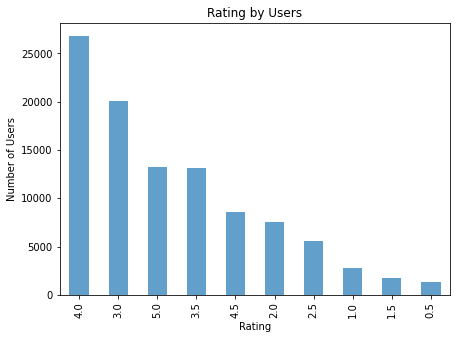

In [28]:
df['rating'].value_counts().plot(kind='bar', alpha=0.7, figsize=(7,5))
plt.ylabel('Number of Users')
plt.xlabel('Rating')
plt.title('Rating by Users')

- 평점 Top10 유저수

Text(0.5, 1.0, 'Top 10 Movies by Rating')

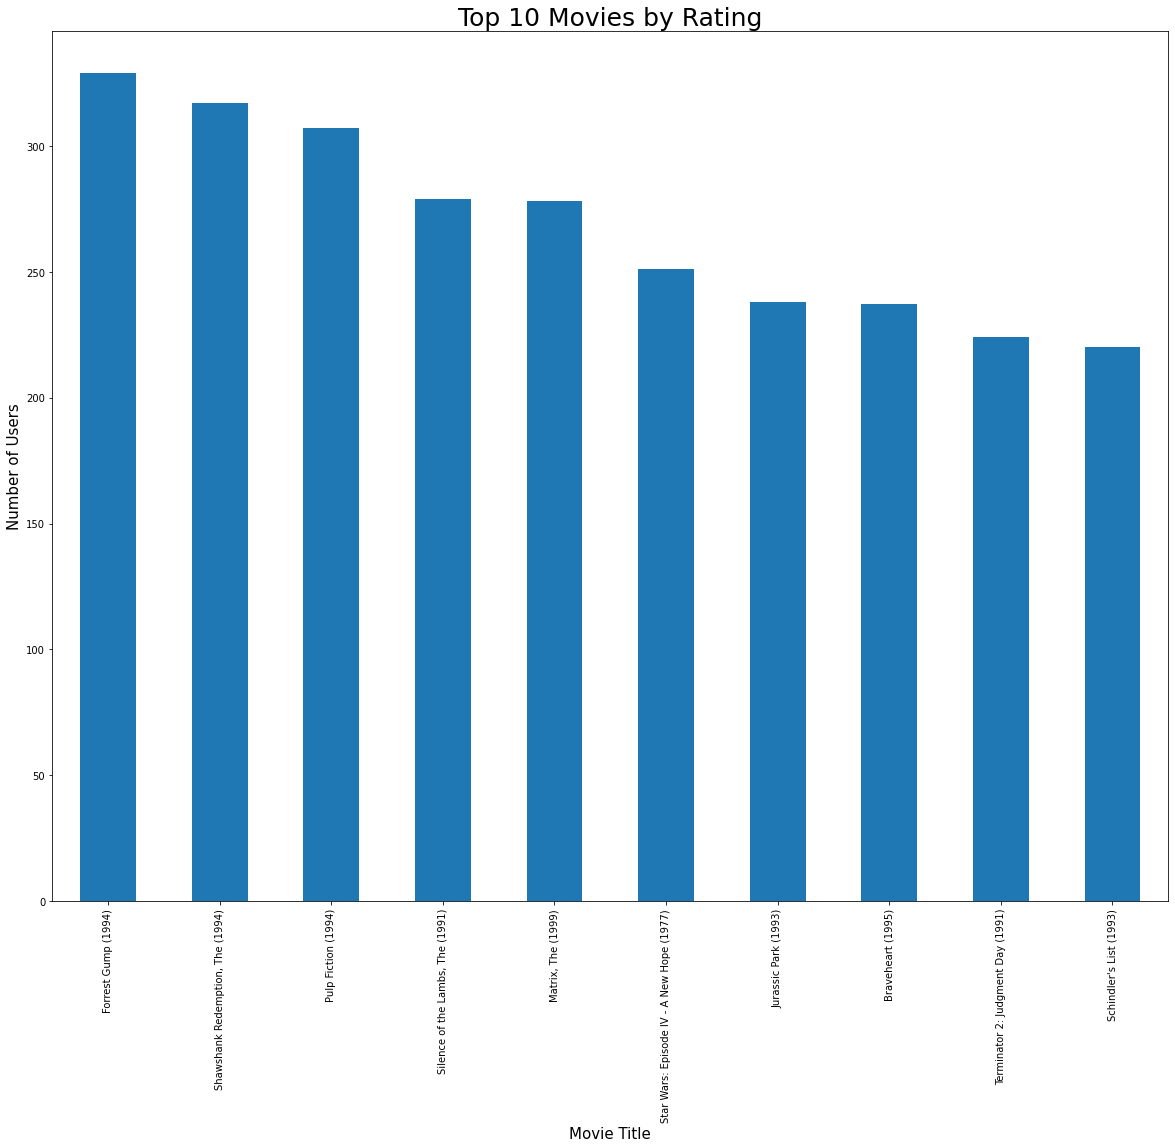

In [34]:
df.groupby('title')['rating'].count().nlargest(10).plot(kind="bar")
plt.xlabel('Movie Title', fontsize = 15)
plt.ylabel('Number of Users', fontsize = 15)
plt.title('Top 10 Movies by Rating', fontsize = 25)

- 장르별 영화수

In [12]:
genre_dict = {}
for index, row in movies.iterrows():
    genre_combination = row['genres']
    parsed_genre = genre_combination.split('|')
    
    for genre in parsed_genre:
        if genre in genre_dict:
            genre_dict[genre] += 1
        else:
            genre_dict[genre] = 1            

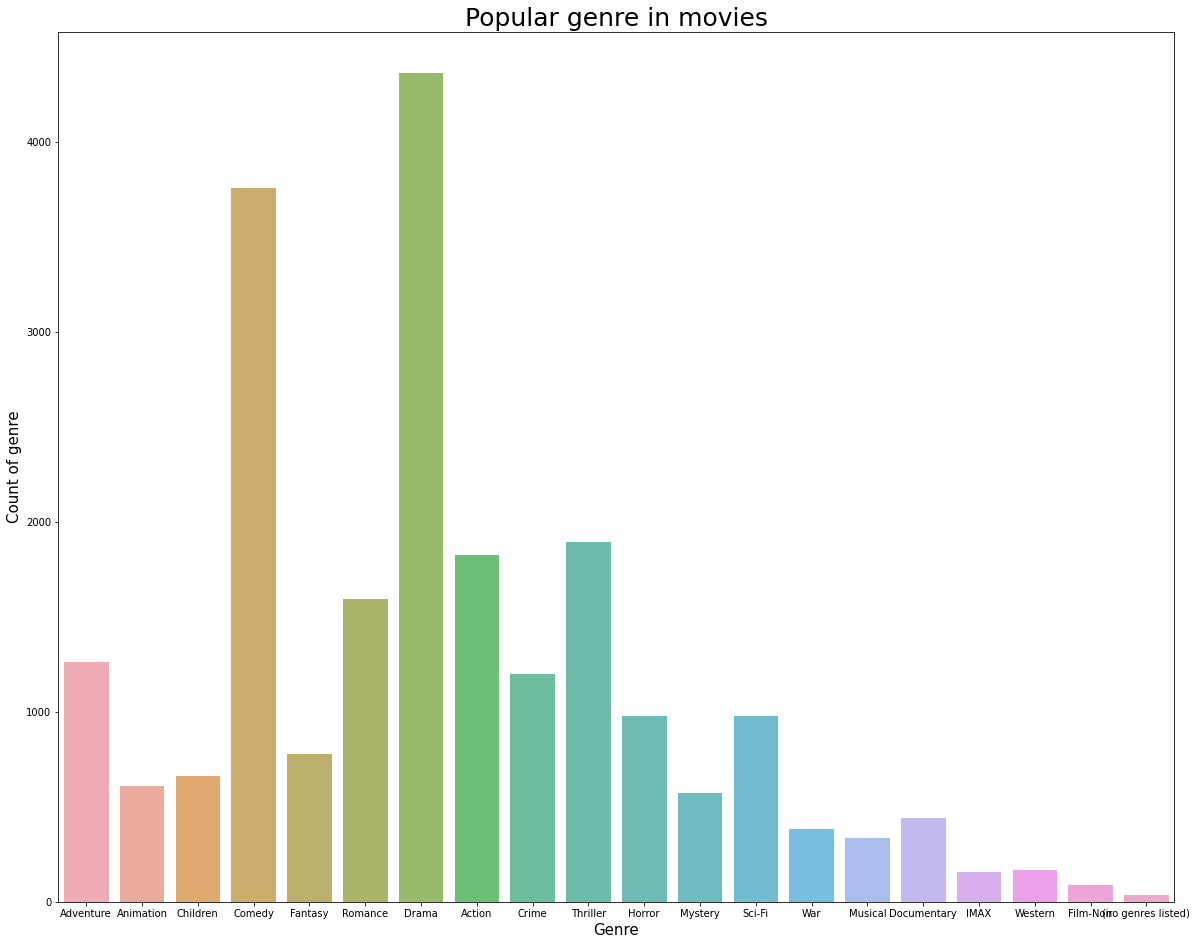

In [13]:
plt.rcParams['figure.figsize'] = [20,16]
sns.barplot(list(genre_dict.keys()), list(genre_dict.values()),
           alpha=0.8)
plt.title('Popular genre in movies', fontsize=25)
plt.ylabel('Count of genre', fontsize=15)
plt.xlabel('Genre', fontsize=15)
plt.show()

In [9]:
data.groupby('title').size().sort_values(ascending=False)[:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
dtype: int64

# Memory Based CF

## Item Based CF (IBCF)

In [35]:
# title 컬럼을 얻기 이해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# 행은 userID, 열은 title로 pivoting 수행. rating이 없는 값(NaN)은 모두 0으로 변환
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title', fill_value=0)

print(ratings_matrix.shape)
ratings_matrix.head()

(610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,4.0,0
2,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
5,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


In [37]:
startTime = time.time()

# cosine_similarity()는 행을 기준으로 유사도를 계산하기 때문에 ratings_matrix를 transpose한 후 적용
item_sim = cosine_similarity(ratings_matrix.T, ratings_matrix.T)

# cosine_similarity()로 반환된 numpy 행렬에 영화명을 매핑하기 위해 DataFrame으로 변환
item_sim = pd.DataFrame(item_sim, ratings_matrix.columns, ratings_matrix.columns)

print(item_sim.shape)
item_sim.head()

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Salem's Lot (2004),0.0,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Til There Was You (1997),0.0,0.000000,0.000000,0.857493,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [38]:
# 2010년에 개봉된 "인셉션"과 유사도가 높은 상위 5개 영화 리스트
item_sim["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

### 영화평점 예측

In [39]:
# 유사도가 가장 높은 이웃의 수 설정
K = 20

In [40]:
# 위의 평점예측 수식을 아래와 같이 구현함
R, S = ratings_matrix.values, item_sim.values
# 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
ratings_pred = np.zeros(R.shape)

# 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행. 
for i in range(R.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 K개 데이터 행렬의 index 반환
    top_k = np.argsort(S[:, i])[::-1][1:K+1]
    # 개인화된 예측 평점을 계산
    for u in range(R.shape[0]):
        ratings_pred[u, i] = S[i, :][top_k].dot(R[u, :][top_k].T) 
        ratings_pred[u, i] /= np.sum(np.abs(S[i, :][top_k]))
        
ratings_pred = pd.DataFrame(ratings_pred, ratings_matrix.index, ratings_matrix.columns)
ratings_pred

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.237854,0.000000,0.000000,1.343209,0.295905
2,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.237854,0.000000,0.000000,0.207538,0.000000
5,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000,0.157715,0.0,0.540565,0.176643,0.0,0.138338,0.0,0.117417,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.536920,0.281261,0.000000,0.740281,0.197292
607,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.210006,0.000000,0.000000,0.000000,0.000000
608,0.000,0.000000,0.0,0.169467,0.000000,0.0,0.259268,0.0,0.211351,0.0,...,0.0,0.135076,0.000000,0.114401,0.0,1.149726,3.009715,0.181837,0.748254,0.000000


In [41]:
# 추천 알고리즘 간에 실행시간을 비교하기 위한 코드 
endTime = time.time() - startTime

### Top-N 영화 추천

In [42]:
# 추천 영화의 수 설정
N = 10
uid = 9

In [43]:
# id로 지정된 사용자의 모든 영화정보 추출하여 Series로 반환함
# 반환된 user_rating은 영화명(title)을 index로 가지는 Series 객체임 
user_rating = ratings_matrix.loc[uid,:]
    
# user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list로 만듬
already_seen = user_rating[user_rating > 0].index.tolist()
   
# list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함
unseen_list = [movie for movie in ratings_matrix.columns.tolist() if movie not in already_seen]
    
# unseen_list에서 가장 평점이 높은 N개의 영화를 추천함 
recomm_items = ratings_pred.loc[uid, unseen_list].sort_values(ascending=False)[:N]
list(recomm_items.index)

['Gladiator (2000)',
 'Shrek (2001)',
 'Spider-Man (2002)',
 'Last Samurai, The (2003)',
 'Indiana Jones and the Temple of Doom (1984)',
 'Matrix Reloaded, The (2003)',
 "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)",
 'Matrix, The (1999)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
 'Monsters, Inc. (2001)']

### 성능평가

In [46]:
# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 RMSE를 구함
actual, pred = ratings_matrix.values, ratings_pred.values     
pred = pred[actual.nonzero()].flatten()
actual = actual[actual.nonzero()].flatten()
rmse = np.sqrt(mean_squared_error(pred, actual))
print('RMSE of IBCF@K=20: ', rmse)
print(f'Speed of IBCF@K=20: {endTime} sec.')

RMSE of IBCF@K=20:  2.132971466411431
Speed of IBCF@K=20: 82.2315878868103 sec.


## User Based CF (UBCF)

In [47]:
startTime = time.time()

# cosine_similarity()는 행을 기준으로 유사도를 계산하기 때문에 ratings_matrix를 transpose한 후 적용
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 영화명을 매핑하기 위해 DataFrame으로 변환
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

print(user_sim.shape)
user_sim.head()

(610, 610)


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792


In [48]:
# Id=9인 사용자와 유사도가 높은 상위 5명 리스트
user_sim.loc[9].sort_values(ascending=False)[1:6]

userId
508    0.209600
165    0.199900
399    0.168494
77     0.167616
407    0.149953
Name: 9, dtype: float64

### 영화평점 예측

In [49]:
# 유사도가 가장 높은 이웃의 수 설정
K = 20

In [50]:
# 위의 평점예측 수식을 아래와 같이 구현함
R, S = ratings_matrix.values, user_sim.values
# 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
ratings_pred = np.zeros(R.shape)

# 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행. 
for u in range(R.shape[0]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 index 반환
    top_k = np.argsort(S[:, u])[::-1][1:K+1]
    # 개인화된 예측 평점을 계산
    for i in range(R.shape[1]):
        ratings_pred[u, i] = S[u, :][top_k].dot(R[:,i][top_k].T) 
        ratings_pred[u, i] /= np.sum(np.abs(S[u, :][top_k]))
        
ratings_pred = pd.DataFrame(ratings_pred, ratings_matrix.index, ratings_matrix.columns)
ratings_pred

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.761716,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.199473,0.000000,0.000000,0.689137,0.000000
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.140703,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.21164,0.0,0.0,0.0,0.767511,0.000000,0.000000,0.000000,...,0.000000,0.139740,0.000000,0.000000,0.0,0.229173,0.000000,0.000000,0.810881,0.059676
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.048357,0.145070,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.847966,0.000000,0.000000,0.672517,0.000000
5,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.00000,0.0,0.0,0.0,0.623651,0.190962,1.140993,0.451218,...,0.000000,0.166449,0.000000,0.000000,0.0,1.754855,0.487880,0.000000,0.860133,0.000000
607,0.0,0.0,0.00000,0.0,0.0,0.0,0.645987,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.645925,0.164652,0.000000,0.427383,0.000000
608,0.0,0.0,0.00000,0.0,0.0,0.0,0.498297,0.000000,0.529341,0.276509,...,0.000000,0.425780,0.139827,0.139827,0.0,0.984341,1.022557,0.110134,0.744544,0.000000


In [51]:
# 추천 알고리즘 간에 실행시간을 비교하기 위한 코드 
endTime = time.time() - startTime

### Top-N 영화 추천

In [52]:
# 추천 영화의 수 설정
N = 10
uid = 9

In [53]:
# id로 지정된 사용자의 모든 영화정보 추출하여 Series로 반환함
# 반환된 user_rating은 영화명(title)을 index로 가지는 Series 객체임 
user_rating = ratings_matrix.loc[uid,:]
    
# user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list로 만듬
already_seen = user_rating[user_rating > 0].index.tolist()
   
# list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함
unseen_list = [movie for movie in ratings_matrix.columns.tolist() if movie not in already_seen]
    
# unseen_list에서 가장 평점이 높은 N개의 영화를 추천함 
recomm_items = ratings_pred.loc[uid, unseen_list].sort_values(ascending=False)[:N]
list(recomm_items.index)

['Matrix, The (1999)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Indiana Jones and the Last Crusade (1989)',
 'Saving Private Ryan (1998)',
 'Forrest Gump (1994)',
 'Terminator 2: Judgment Day (1991)',
 'Jurassic Park (1993)']

### 추천성능 평가

In [54]:
# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 RMSE를 구함
actual, pred = ratings_matrix.values, ratings_pred.values     
pred = pred[actual.nonzero()].flatten()
actual = actual[actual.nonzero()].flatten()
rmse = np.sqrt(mean_squared_error(pred, actual))
print('RMSE of UBCF@K=20: ', rmse)
print(f'Speed of UBCF@K=20: {endTime} sec.')

RMSE of UBCF@K=20:  2.52393545743251
Speed of UBCF@K=20: 78.22738289833069 sec.


# Model Based CF

## Matrix Factorization CF (MFCF)

In [55]:
def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트. 
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

In [56]:
startTime = time.time()

P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.20685455302331537
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720403
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.17165226964707486
### iteration step :  120  rmse :  0.1669518194687172
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679643
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715428
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  r

### 영화 평점 예측

In [57]:
ratings_pred = np.dot(P, Q.T)
ratings_pred = pd.DataFrame(ratings_pred, ratings_matrix.index, ratings_matrix.columns)
ratings_pred

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941
4,2.628629,3.035550,2.575746,3.706912,3.430636,0.706441,3.330280,1.978826,4.560368,2.775710,...,1.046116,2.912178,2.479592,2.231915,1.888629,2.211364,0.645603,1.585734,3.542892,0.591540
5,2.116148,3.084761,2.747679,3.783490,3.946990,0.883259,1.958953,1.757317,2.054312,2.775258,...,0.956159,3.893975,2.717024,2.002443,2.053337,3.983639,2.099626,1.423718,2.490428,0.531403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.153469,3.536398,3.128222,3.875599,3.821362,1.010045,2.284450,2.287194,4.148796,3.487517,...,1.105429,3.647394,3.342759,2.446343,2.406133,3.613071,1.849264,1.526109,2.860815,0.673099
607,2.502048,3.577547,3.095692,4.081789,4.038996,1.095224,3.698198,1.904581,5.347442,3.114650,...,0.963407,3.230442,3.526719,2.084052,2.119598,4.135631,3.124109,2.362195,3.421672,0.758574
608,2.154503,3.019060,2.679379,3.567550,3.483444,0.909505,2.387003,1.644313,3.090541,3.197815,...,0.818661,3.372644,2.936734,2.049884,2.097775,4.452331,3.504461,1.906708,2.419560,0.701739


In [58]:
# 추천 알고리즘 간에 실행시간을 비교하기 위한 코드 
endTime = time.time() - startTime

### Top-N 영화 추천

In [59]:
# 추천 영화의 수 설정
N = 10
uid = 9

In [60]:
# id로 지정된 사용자의 모든 영화정보 추출하여 Series로 반환함
# 반환된 user_rating은 영화명(title)을 index로 가지는 Series 객체임 
user_rating = ratings_matrix.loc[uid,:]
    
# user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list로 만듬
already_seen = user_rating[user_rating > 0].index.tolist()
   
# list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함
unseen_list = [movie for movie in ratings_matrix.columns.tolist() if movie not in already_seen]
    
# unseen_list에서 가장 평점이 높은 N개의 영화를 추천함 
recomm_items = ratings_pred.loc[uid, unseen_list].sort_values(ascending=False)[:N]
list(recomm_items.index)

['Rear Window (1954)',
 'South Park: Bigger, Longer and Uncut (1999)',
 'Rounders (1998)',
 'Blade Runner (1982)',
 'Roger & Me (1989)',
 'Gattaca (1997)',
 'Ben-Hur (1959)',
 'Rosencrantz and Guildenstern Are Dead (1990)',
 'Big Lebowski, The (1998)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)']

### 추천성능 평가

In [61]:
# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 RMSE를 구함
actual, pred = ratings_matrix.values, ratings_pred.values     
pred = pred[actual.nonzero()].flatten()
actual = actual[actual.nonzero()].flatten()
rmse = np.sqrt(mean_squared_error(pred, actual))
print('RMSE of MFCF: ', rmse)
print(f'Speed of MFCF: {endTime} sec.')

RMSE of MFCF:  0.1475549689686697
Speed of MFCF: 259.56728649139404 sec.


## Surprise Package

In [ ]:
import surprise
print(surprise.__version__)

from surprise import SVD, Reader, Dataset, accuracy 
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise.dataset import DatasetAutoFolds

### Data Setting

In [ ]:
# surprise의 Reader 클래스는 헤더가 없는 CSV 형식의 평점 화일을 요구함
pd.read_csv('ratings.csv').to_csv('ratings_noh.csv', index=False, header=False)

# 평점화일이 user, item, rating, timestamp 순으로 필드가 구성되어 있는다는 것을 알려줘야 함
# 또한 최소 평점과 최대 평점을 지정해야 함
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('ratings_noh.csv', reader)

### Split Data

In [ ]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

### Modeling

In [ ]:
model = SVD(n_factors=50, n_epochs=20, biased=True, random_state=0)
model.fit(trainset)

### Evaluation

In [ ]:
predictions = model.test(testset)
accuracy.rmse(predictions)

### Cross-Validation

In [ ]:
model = SVD(random_state=0) 
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

### Hyper Parameter Tunning

In [ ]:
# 최적화할 파라미터들을 딕셔너리 형태로 지정. 
param_grid = {'n_epochs': [20, 40], 'n_factors': [50, 100] }

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse 로 수행 하도록 GridSearchCV 구성
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
grid_search.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(grid_search.best_score['rmse'])
print(grid_search.best_params['rmse'])

### Recommendation

In [ ]:
rating_movies = pd.merge(ratings, movies, on='movieId')
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title', fill_value=0)

# 학습 데이터 생성
# train_test_split( )으로 분리되지 않는 Dataset에 fit( )을 호출하면 오류 발생
# 전체 데이터를 학습 데이터로 사용하려면 DatasetAutoFolds 클래스를 사용해야 함 
data_folds = DatasetAutoFolds(ratings_file='ratings_noh.csv', reader=reader)

#전체 데이터를 학습데이터로 생성함. 
trainset = data_folds.build_full_trainset()

### 영화 평점 예측

In [ ]:
model = SVD(n_epochs=20, n_factors=50, random_state=0)
model.fit(trainset)

In [ ]:
### Top-N 영화 추천

In [ ]:
# 추천 영화의 수 설정
N = 10
uid = 9

In [ ]:
#testset = trainset.build_anti_testset()
#predictions = model.test(testset)

ratings_pred = np.zeros((1, ratings_matrix.shape[1]))
for i in range(ratings_matrix.shape[1]):
    ratings_pred[0,i] = model.predict(str(uid), str(i))[3]
    
ratings_pred = pd.DataFrame(ratings_pred, columns=ratings_matrix.columns)
ratings_pred 

In [ ]:
# id로 지정된 사용자의 모든 영화정보 추출하여 Series로 반환함
# 반환된 user_rating은 영화명(title)을 index로 가지는 Series 객체임 
user_rating = ratings_matrix.loc[uid,:]
    
# user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list로 만듬
already_seen = user_rating[user_rating > 0].index.tolist()
   
# list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함
unseen_list = [movie for movie in ratings_matrix.columns.tolist() if movie not in already_seen]

# unseen_list에서 가장 평점이 높은 N개의 영화를 추천함 
recomm_items = ratings_pred.loc[0, unseen_list].sort_values(ascending=False)[:N]
list(recomm_items.index)